# Word Level Federated Text Generation with Stack Overflow with and without Pretrained Word Embeddings
- Joel Stremmel
- 02-10-20
- GCP 

**About:**

This notebook loads the Stack Overflow data available through `tff.simulation.datasets` and trains an LSTM model with Federared Averaging by following the Federated Learning for Text Generation [example notebook](https://github.com/tensorflow/federated/blob/master/docs/tutorials/federated_learning_for_text_generation.ipynb).  The embedding layer in the LSTM is optionally initialized with either GloVe or FastText Embeddings.

**Notes:**

- This notebook prepares the Stack Overflow dataset for word level language modeling using this [module](https://github.com/tensorflow/federated/blob/master/tensorflow_federated/python/research/baselines/stackoverflow/dataset.py
).
- The metrics for model training come from this [module](https://github.com/tensorflow/federated/blob/master/tensorflow_federated/python/research/baselines/stackoverflow/metrics.py). 


**Data:** 
- https://www.kaggle.com/stackoverflow/stackoverflow

**License:** 
- https://creativecommons.org/licenses/by-sa/3.0/

**Data and Model References:**
- https://www.tensorflow.org/federated/api_docs/python/tff/simulation/datasets/stackoverflow/load_data
- https://github.com/tensorflow/federated/blob/master/docs/tutorials/federated_learning_for_text_generation.ipynb
- https://github.com/tensorflow/federated/tree/master/tensorflow_federated/python/research/baselines/stackoverflow
- https://www.tensorflow.org/tutorials/text/text_generation

**Environment Setup References:**
- https://www.tensorflow.org/install/gpu
- https://gist.github.com/matheustguimaraes/43e0b65aa534db4df2918f835b9b361d
- https://www.tensorflow.org/install/source#tested_build_configurations
- https://anbasile.github.io/programming/2017/06/25/jupyter-venv/

### Environment Setup
Pip install these packages in the order listed.

In [1]:
# !sudo pip install --upgrade pip
# !pip install --upgrade tensorflow-federated
# !pip uninstall tensorflow
# !pip install --upgrade tensorflow-gpu==2.0
# !pip install --upgrade matplotlib
# !pip install nest_asyncio

### Imports

In [2]:
import nest_asyncio
nest_asyncio.apply()

In [3]:
import os, sys, io
sys.path.append(os.path.dirname(os.getcwd()))

In [4]:
import collections
import functools
import six
import time
import string

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_federated as tff

In [5]:
from src import dataset, metrics, embeddings, model, validation, federated, generate_text

### Set Compatability Behavior

In [6]:
tf.compat.v1.enable_v2_behavior()

### Check Tensorflow Install

In [7]:
print('Built with Cuda: {}'.format(tf.test.is_built_with_cuda()))
print('Build with GPU support: {}'.format(tf.test.is_built_with_gpu_support()))
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Built with Cuda: True
Build with GPU support: True
Num GPUs Available:  1


### Test TFF

In [8]:
tff.federated_computation(lambda: 'Hello, World!')()

'Hello, World!'

### Set Some Parameters for Preprocessing the Data and Training the Model
**Note:** Ask Keith how he's been setting there for internal experiments.

In [9]:
VOCAB_SIZE = 10000
BATCH_SIZE = 8
CLIENTS_EPOCHS_PER_ROUND = 1
MAX_SEQ_LENGTH = 20
MAX_ELEMENTS_PER_USER = 5000
CENTRALIZED_TRAIN = False
SHUFFLE_BUFFER_SIZE = 1000
NUM_VALIDATION_EXAMPLES = 10000
NUM_TEST_EXAMPLES = 2

NUM_ROUNDS = 5
NUM_TRAIN_CLIENTS = 10

EMBEDDING_DIM = 100
EMBEDDING_PATH = ''
# EMBEDDING_PATH = '../word_embeddings/glove/glove.6B.{}d.txt'.format(EMBEDDING_DIM)
# EMBEDDING_PATH = '../word_embeddings/fasttext/wiki-news-{}d-1M.vec'.format(EMBEDDING_DIM)

RNN_UNITS = 100

### Load and Preprocess Word Level Datasets

In [10]:
train_data, val_data, test_data = dataset.construct_word_level_datasets(
    vocab_size=VOCAB_SIZE,
    batch_size=BATCH_SIZE,
    client_epochs_per_round=CLIENTS_EPOCHS_PER_ROUND,
    max_seq_len=MAX_SEQ_LENGTH,
    max_elements_per_user=MAX_ELEMENTS_PER_USER,
    centralized_train=CENTRALIZED_TRAIN,
    shuffle_buffer_size=SHUFFLE_BUFFER_SIZE,
    num_validation_examples=NUM_VALIDATION_EXAMPLES,
    num_test_examples=NUM_TEST_EXAMPLES)

/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


### Retrieve the Dataset Vocab

In [11]:
vocab = dataset.get_vocab(vocab_size=VOCAB_SIZE)

### Retrieve the Special Characters Created During Preprocessing
The four special tokens are:
- pad: padding token
- oov: out of vocabulary
- bos: begin of sentence
- eos: end of sentence

In [12]:
pad, oov, bos, eos = dataset.get_special_tokens(vocab_size=VOCAB_SIZE)

In [13]:
special2idx = dict(zip(['pad', 'oov', 'bos', 'eos'], [pad, oov, bos, eos]))
idx2special = {v:k for k, v in special2idx.items()}

### Set Vocabulary
Add one to account for the pad token which has idx 0.

In [14]:
word2idx = {word:i+1 for i, word in enumerate(vocab)}
idx2word = {i+1:word for i, word in enumerate(vocab)}

### Add Special Characters

In [15]:
word2idx = {**word2idx, **special2idx}
idx2word = {**idx2word, **idx2special}

### Reset Vocab Size
This accounts for having added the special characters.

In [16]:
EXTENDED_VOCAB_SIZE = VOCAB_SIZE + len(special2idx)

### Load Pretrained Word Embeddings
- Either [GloVe embeddings from Stanford](https://nlp.stanford.edu/projects/glove/) - license [here](https://www.opendatacommons.org/licenses/pddl/1.0/)
- Or [FastText embeddings from Facebook](https://fasttext.cc/docs/en/english-vectors.html) - license [here](https://creativecommons.org/licenses/by-sa/3.0/)

### Create Embedding Matrix from Words in Word Index and Word Embeddings
If `EMBEDDING_PATH` is an empy string, the embedding matrix in the embedding layer is initialized according to the random uniform distribution used by the tf.keras embedding layer by passing the 'uniform' string as an argument to the `embedding_initializer` in the `build_model` function.

In [17]:
if EMBEDDING_PATH:
    embedding_matrix=embeddings.create_matrix_from_pretrained_embeddings(
        embedding_path=EMBEDDING_PATH,
        embedding_dim=EMBEDDING_DIM,
        word2idx=word2idx)
else:
    embedding_matrix = 'uniform'

### Load or Build the Model and Try Generating Some Text

In [18]:
keras_model = model.build_model(extended_vocab_size=EXTENDED_VOCAB_SIZE,
                                embedding_dim=EMBEDDING_DIM,
                                embedding_matrix=embedding_matrix,
                                rnn_units=RNN_UNITS)

generate_text.generate_text(model=keras_model,
                            word2idx=word2idx,
                            idx2word=idx2word,
                            start_string='How are you today')

'how are you today weak soup usr hg solr fiddler roles workspace repeated greatest deletions stopping orthogonal contributed agent populates compromised essence connector beware bi 777 apt stored partitioned cleaned temporary reveal 4-5 downloading viewdidload redundant dangling demand datastore darker versioned challenges persistence # prior kitkat fourth apps sits behaves inspector ah curiosity ipv4'

### Create TFF Version of the Model to be Trained with Federated Averaging
- TFF uses a sample batch so it knows the types and shapes that your model expects.
- The model function then builds and compiles the model and creates a TFF version to be trained.

In [19]:
sample_batch = tf.nest.map_structure(lambda x: x.numpy(), next(iter(val_data)))

/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


### Initialize Train and Validation Model Trackers to be Used Below

In [20]:
evaluation_metric_names = ['loss',
                           'num_tokens',
                           'num_tokens_no_oov',
                           'num_batches',
                           'num_examples',
                           'accuracy',
                           'accuracy_no_oov',
                           'accuracy_no_oov_no_oes']

train_metrics_tracker = validation.model_history_tracker(metric_names=evaluation_metric_names)
val_metrics_tracker = validation.model_history_tracker(metric_names=evaluation_metric_names)

### Set the Default Executor

In [21]:
tff.framework.set_default_executor(tff.framework.create_local_executor(max_fanout=10))

### Create an Iterative Process

In [22]:
iterative_process = (
      tff.learning.federated_averaging.build_federated_averaging_process(
          model_fn=lambda : model.model_fn(extended_vocab_size=EXTENDED_VOCAB_SIZE,
                        embedding_dim=EMBEDDING_DIM,
                        embedding_matrix=embedding_matrix,
                        rnn_units=RNN_UNITS,
                        vocab_size=VOCAB_SIZE,
                        sample_batch=sample_batch),
          server_optimizer_fn=federated.server_optimizer_fn,
          client_weight_fn=federated.client_weight_fn))

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


### Initalize the Process
Server state will be updated in the training loop.

In [23]:
server_state = iterative_process.initialize()

### Train Model Across Many Randomly Sampled Clients with Federated Averaging

Evaluating before training round #0 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


100/100 [==============================] - 19s 193ms/step - loss: 6.3614 - num_tokens: 130962.0000 - num_tokens_no_oov: 126764.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 6.1086e-05 - accuracy_no_oov: 6.3109e-05 - accuracy_no_oov_no_eos: 6.7052e-05
Sampling 10 new clients.
Round: 0
   Loss: 6.80537796
   num_batches: 420
   num_examples: 3317
   num_tokens: 45281
   num_tokens_no_oov: 44105
   accuracy: 0.00009
   accuracy_no_oov: 0.00007
Evaluating before training round #1 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


100/100 [==============================] - 19s 188ms/step - loss: 6.4521 - num_tokens: 133228.0000 - num_tokens_no_oov: 128671.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0027 - accuracy_no_oov: 0.0028 - accuracy_no_oov_no_eos: 0.0029
Sampling 10 new clients.
Round: 1
   Loss: 6.23803425
   num_batches: 457
   num_examples: 3623
   num_tokens: 47958
   num_tokens_no_oov: 46574
   accuracy: 0.00065
   accuracy_no_oov: 0.00067
Evaluating before training round #2 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


100/100 [==============================] - 20s 204ms/step - loss: 6.5175 - num_tokens: 134657.0000 - num_tokens_no_oov: 130741.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 2.2279e-05 - accuracy_no_oov: 2.2946e-05 - accuracy_no_oov_no_eos: 2.4291e-05
Sampling 10 new clients.
Round: 2
   Loss: 6.57399988
   num_batches: 420
   num_examples: 3332
   num_tokens: 45083
   num_tokens_no_oov: 43748
   accuracy: 0.00000
   accuracy_no_oov: 0.00000
Evaluating before training round #3 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


100/100 [==============================] - 17s 174ms/step - loss: 6.0727 - num_tokens: 124370.0000 - num_tokens_no_oov: 121127.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.
Round: 3
   Loss: 5.36992550
   num_batches: 717
   num_examples: 5696
   num_tokens: 73842
   num_tokens_no_oov: 71532
   accuracy: 0.01208
   accuracy_no_oov: 0.01247
Evaluating before training round #4 on 10000 examples.


/home/joel_stremmel/anaconda3/envs/tff/lib/python3.7/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


100/100 [==============================] - 19s 190ms/step - loss: 6.4309 - num_tokens: 132806.0000 - num_tokens_no_oov: 128230.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 10 new clients.
Round: 4
   Loss: 5.76808500
   num_batches: 446
   num_examples: 3548
   num_tokens: 41087
   num_tokens_no_oov: 39931
   accuracy: 0.00000
   accuracy_no_oov: 0.00000


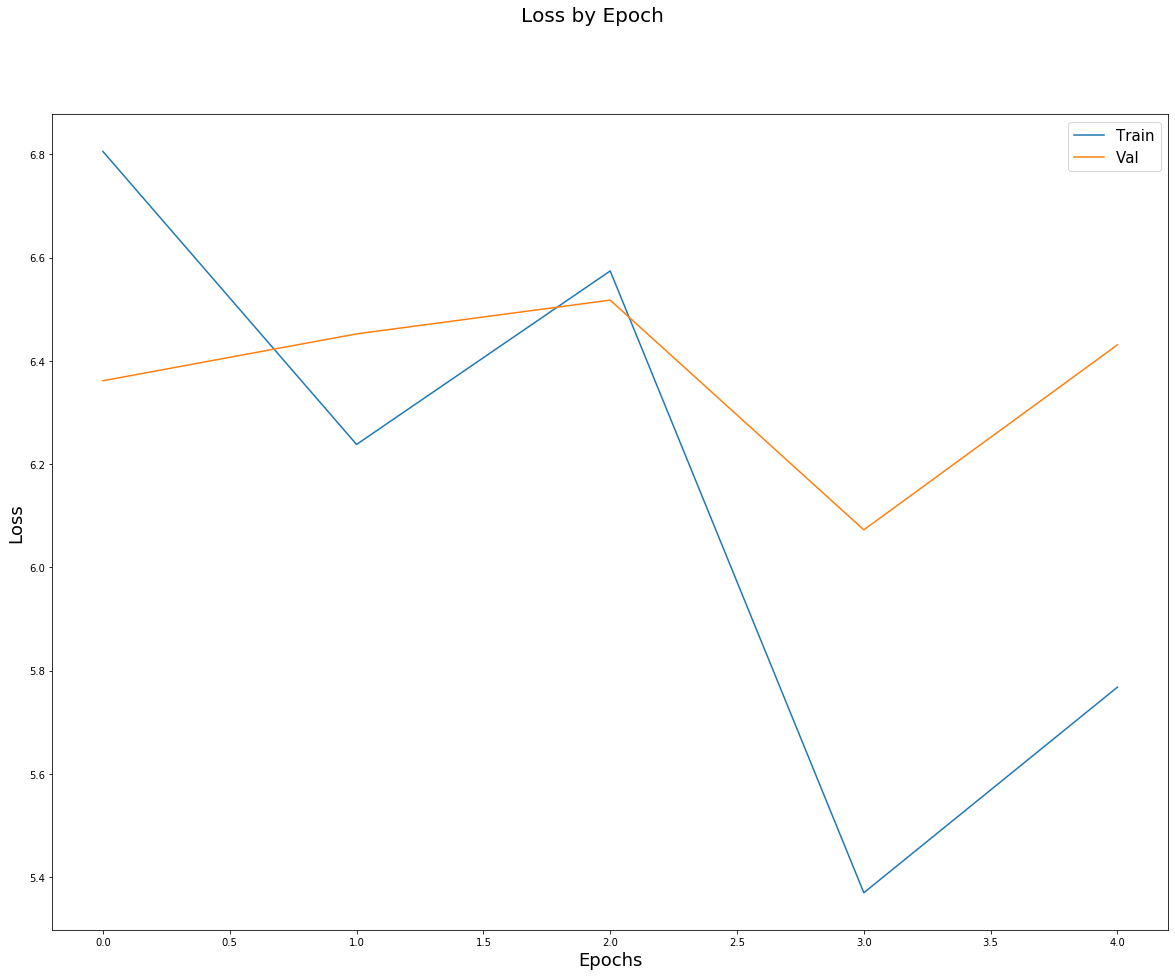

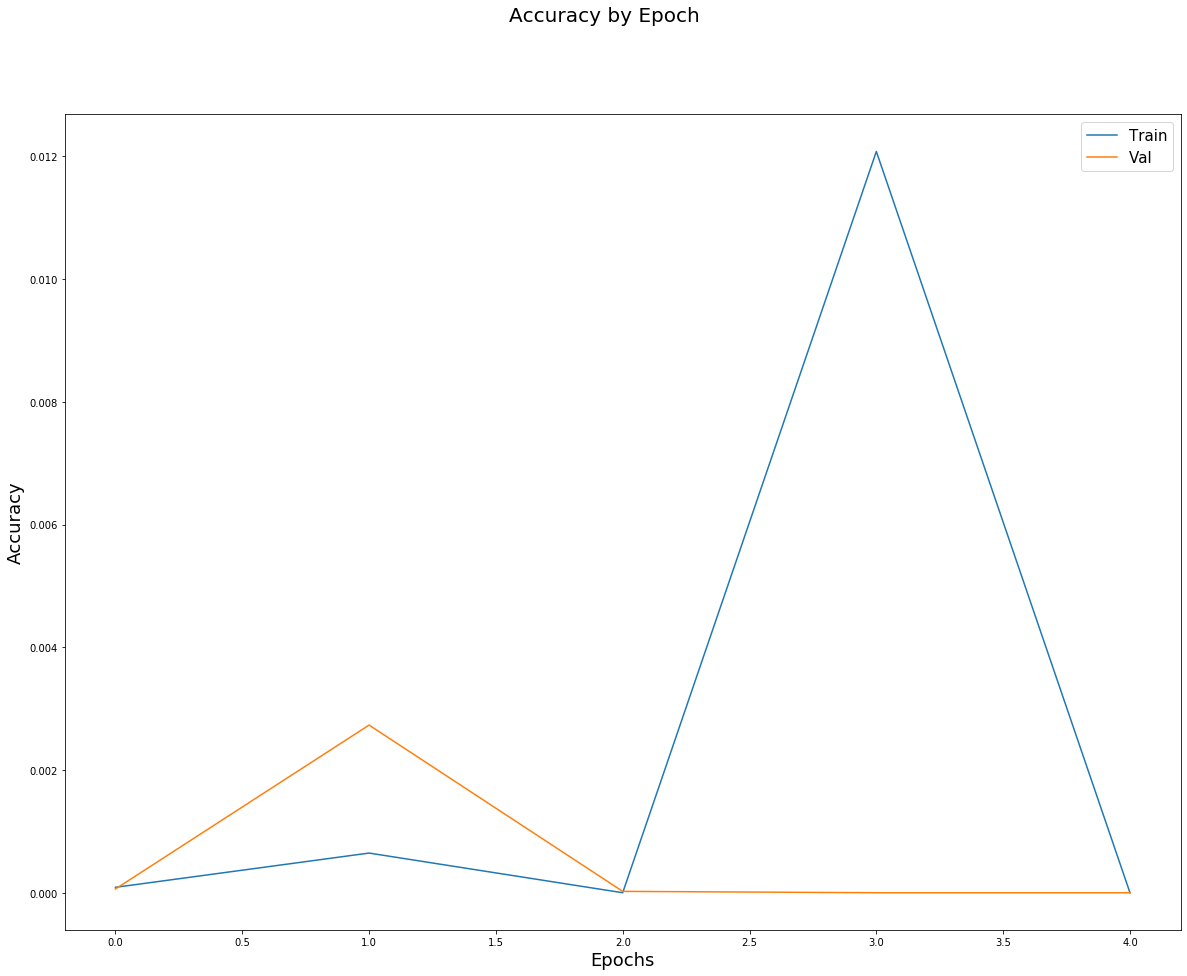

In [24]:
try:
    for round_num in range(0, NUM_ROUNDS):

        # Examine validation metrics
        print('Evaluating before training round #{} on {} examples.'.format(round_num, NUM_VALIDATION_EXAMPLES))
        validation.keras_evaluate(state=server_state,
                                  val_dataset=val_data,
                                  extended_vocab_size=EXTENDED_VOCAB_SIZE,
                                  vocab_size=VOCAB_SIZE,
                                  embedding_dim=EMBEDDING_DIM,
                                  embedding_matrix=embedding_matrix,
                                  rnn_units=RNN_UNITS,
                                  metrics_tracker=val_metrics_tracker)

        # Sample train clients to create a train dataset
        print('Sampling {} new clients.'.format(NUM_TRAIN_CLIENTS))
        train_clients = federated.get_sample_clients(dataset=train_data, num_clients=NUM_TRAIN_CLIENTS)
        train_datasets = [train_data.create_tf_dataset_for_client(client) for client in train_clients]

        # Apply federated training round
        server_state, server_metrics = iterative_process.next(server_state, train_datasets)

        # Examine training metrics
        print('Round: {}'.format(round_num))
        print('   Loss: {:.8f}'.format(server_metrics.loss))
        print('   num_batches: {}'.format(server_metrics.num_batches))
        print('   num_examples: {}'.format(server_metrics.num_examples))
        print('   num_tokens: {}'.format(server_metrics.num_tokens))
        print('   num_tokens_no_oov: {}'.format(server_metrics.num_tokens_no_oov))
        print('   accuracy: {:.5f}'.format(server_metrics.accuracy))
        print('   accuracy_no_oov: {:.5f}'.format(server_metrics.accuracy_no_oov))

        # Add train metrics to tracker
        train_metrics_tracker.add_metrics_by_name('loss', server_metrics.loss)
        train_metrics_tracker.add_metrics_by_name('accuracy', server_metrics.accuracy)
        
        # Save loss and accuracy from train and validation sets
        np.save('train_loss.npy', train_metrics_tracker.get_metrics_by_name('loss'))
        np.save('val_loss.npy', val_metrics_tracker.get_metrics_by_name('loss'))
        np.save('train_accuracy.npy', train_metrics_tracker.get_metrics_by_name('accuracy'))
        np.save('val_accuracy.npy', val_metrics_tracker.get_metrics_by_name('accuracy'))

except KeyboardInterrupt as ke:
    
    print('Interrupted')
    
except:
    
    import traceback
    traceback.print_exc()
    
finally:
    
    fig, ax = plt.subplots(figsize=(20, 15))
    x_axis = range(0, NUM_ROUNDS)
    ax.plot(x_axis, train_metrics_tracker.get_metrics_by_name('loss'), label='Train')
    ax.plot(x_axis, val_metrics_tracker.get_metrics_by_name('loss'), label='Val')
    ax.legend(loc='best', prop={'size': 15})
    fig.suptitle('Loss by Epoch', fontsize=20)
    plt.xlabel('Epochs', fontsize=18)
    plt.ylabel('Loss', fontsize=18)
    plt.show()
    
    fig2, ax2 = plt.subplots(figsize=(20, 15))
    ax2.plot(x_axis, train_metrics_tracker.get_metrics_by_name('accuracy'), label='Train')
    ax2.plot(x_axis, val_metrics_tracker.get_metrics_by_name('accuracy'), label='Val')
    ax2.legend(loc='best', prop={'size': 15})
    fig2.suptitle('Accuracy by Epoch', fontsize=20)
    plt.xlabel('Epochs', fontsize=18)
    plt.ylabel('Accuracy', fontsize=18)
    plt.show()

### Load Loss and Accuracy Arrays

In [25]:
train_loss = np.load('train_loss.npy')
train_accuracy = np.load('train_accuracy.npy')
val_loss = np.load('val_loss.npy')
val_accuracy = np.load('val_accuracy.npy')

### Validate Array Sizes

In [26]:
train_loss.shape

(5,)

In [27]:
train_accuracy.shape

(5,)

In [28]:
val_loss.shape

(5,)

In [29]:
val_accuracy.shape

(5,)